In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
df_sample = pd.read_csv("Data_Set.csv")

### Feauter Engineering

In [3]:
import pandas as pd
from sklearn.utils import resample

def balance_fraud_data(df_sample, fraud_column='Fraud Flag'):
    # Separate the fraud and non-fraud cases
    fraud_df = df_sample[df_sample[fraud_column] == 1]
    non_fraud_df = df_sample[df_sample[fraud_column] == 0]

    # Get the counts of fraud and non-fraud cases
    fraud_count = fraud_df.shape[0]
    non_fraud_count = non_fraud_df.shape[0]

    # If non-fraud is larger, we downsample it to match fraud count, else we upsample fraud
    if non_fraud_count > fraud_count:
        non_fraud_df_downsampled = resample(non_fraud_df, 
                                            replace=False,    # sample without replacement
                                            n_samples=fraud_count,   # match fraud count
                                            random_state=42)
        balanced_df = pd.concat([fraud_df, non_fraud_df_downsampled])
    else:
        fraud_df_upsampled = resample(fraud_df, 
                                      replace=True,    # sample with replacement
                                      n_samples=non_fraud_count,   # match non-fraud count
                                      random_state=42)
        balanced_df = pd.concat([fraud_df_upsampled, non_fraud_df])

    return balanced_df
data = balance_fraud_data(df_sample)

In [4]:
data['Fraud Flag'].value_counts()

Fraud Flag
True     75942
False    75942
Name: count, dtype: int64

In [5]:
# Sample regular expressions to extract device_type, os, and browser
data['device_type'] = data['Device Information'].str.extract(r"'device_type': '([^']+)'")
data['os'] = data['Device Information'].str.extract(r"'browser': '\(?([a-zA-Z]+)")
data['browser'] = data['Device Information'].str.extract(r"'os': '([^/]+)")

In [6]:
data['Transaction Date/Time'] = pd.to_datetime(data['Transaction Date/Time'])
data['Day'] = data['Transaction Date/Time'].dt.day
data['Hour'] = data['Transaction Date/Time'].dt.hour
data['Minute'] = data['Transaction Date/Time'].dt.minute


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from geopy.distance import geodesic

# Calculate distance between Latitude and Longitude 
data['Distance'] = 0
for index, row in data.iterrows():
  if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
    data.loc[index, 'Distance'] = geodesic((row['Latitude'], row['Longitude']), (0, 0)).kilometers


# Handle categorical features:
le = LabelEncoder()
categorical_cols = ['POS Entry Mode', 'Transaction Status', 'Merchant Category Code (MCC)', 'Merchant Rating', 'Transaction Type','os','browser',
                    'browser','Income Bracket','Response Time','Transaction Notes']
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Handle missing values 
data.fillna(0, inplace=True)


C:\Users\shere\AppData\Local\Temp\ipykernel_12728\717225588.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10948.619385228105' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[index, 'Distance'] = geodesic((row['Latitude'], row['Longitude']), (0, 0)).kilometers


In [8]:
data.columns

Index(['Transaction ID', 'Transaction Date/Time', 'Transaction Amount',
       'Currency', 'Merchant Name', 'Merchant Category Code (MCC)', 'Location',
       'Latitude', 'Longitude', 'Transaction Type', 'Authorization Code',
       'Fraud Flag', 'Transaction Status', 'POS Entry Mode',
       'Installment Information', 'Merchant ID', 'Terminal ID', 'IP Address',
       'Device Information', 'Transaction Risk Score', 'Loyalty Points Earned',
       'Transaction Notes', 'Cardholder's Income Bracket',
       'Fraud Detection Method', 'Response Time', 'Merchant Rating',
       'Recurring Transaction Flag', 'Customer ID', 'First Name', 'Last Name',
       'Email', 'Phone Number', 'Address', 'City', 'Country', 'Birth Date',
       'Income Bracket', 'Bank Name', 'Card Issuer Country',
       'Transaction Channel', 'Cardholder's Age', 'Cardholder's Gender',
       'Account Balance', 'Remaining Balance', 'Customer State',
       'Customer Zip Code', 'Card Type', 'Card Expiration Date', 'Card Nu

### Modeling

In [9]:

# Split data into features and target variable:
X = data[['Transaction Amount', 'Transaction Risk Score', 'POS Entry Mode', 'Hour', 'Day','Minute','os','browser','Income Bracket',
          'Transaction Status', 'Merchant Category Code (MCC)', 'Merchant Rating', 'Distance',
          'Cardholder\'s Age', 'Account Balance', 'Recurring Transaction Flag',
          'Transaction Type','Transaction Notes','Remaining Balance']]

categorical_cols = ['Transaction Type', 'Transaction Notes', 'Transaction Status', 'Income Bracket', 'POS Entry Mode', 'browser','os']

numerical_cols = ['Transaction Amount', 'Transaction Risk Score', 'Account Balance', 'Recurring Transaction Flag', 'Hour', 
                  'Day', 'Minute', "Cardholder's Age", 'Remaining Balance', 'Merchant Rating', 'Distance','Merchant Category Code (MCC)']

y = data['Fraud Flag']  # Assuming 'Fraudulent' is the target column

# Split data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [10]:
param_grid = {
    'n_estimators': [ 300,400,500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

In [24]:
rm=RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', random_state=42)
rm.fit(X_train_scaled, y_train)

y_pred = rm.predict(X_test_scaled)

In [25]:
y_pred = rm.predict(X_test_scaled)

In [27]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")



Accuracy: 0.8529479540441781
Precision: 0.7739416358405261
Recall: 0.995572004494085
F1-Score: 0.8708772944067062


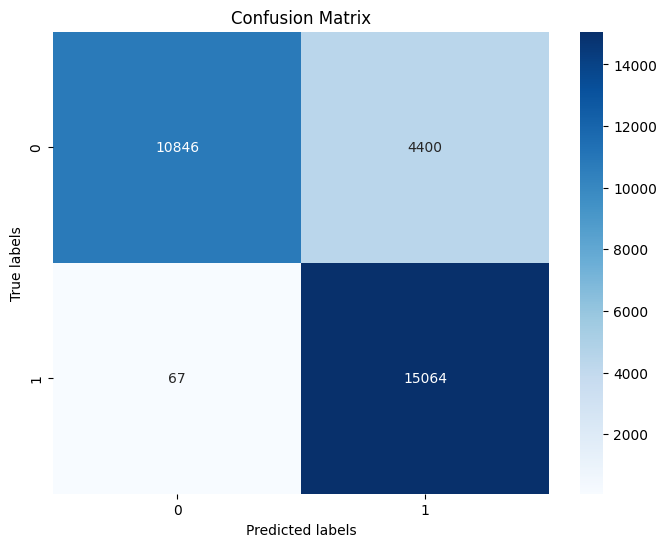

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
#save the model
import joblib
joblib.dump(rm, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']

In [ ]:
#load the model.pkl

import joblib

# Load the model
model = joblib.load('fraud_detection_model.pkl')
